In [ ]:
%matplotlib inline

### Source: [link](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#exercise-computing-word-embeddings-continuous-bag-of-words)

# Word Embeddings: Encoding Lexical Semantics

Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by

\begin{align}\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}\end{align}

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

* We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the `distributional
hypothesis <https://en.wikipedia.org/wiki/Distributional_semantics>`__.


# Getting Dense Word Embeddings

How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

\begin{align}q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]\end{align}

\begin{align}q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]\end{align}

Then we can get a measure of similarity between these words by doing:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}\end{align}

Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{\physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.


You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


# Word Embeddings in Pytorch

Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of my code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).




In [ ]:
# Author: Robert Guthrie
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
torch.manual_seed(1)

In [ ]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


# An Example: N-Gram Language Modeling

Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.

In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()

    # The loss decreased every iteration over the training data!
    print("Loss in Epoch {ep}: {l}".format(ep=epoch, l=np.round(total_loss, 2)))
    losses.append(total_loss)

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
Loss in Epoch 0: 515.64
Loss in Epoch 1: 512.99
Loss in Epoch 2: 510.34
Loss in Epoch 3: 507.72
Loss in Epoch 4: 505.1
Loss in Epoch 5: 502.51
Loss in Epoch 6: 499.93
Loss in Epoch 7: 497.35
Loss in Epoch 8: 494.79
Loss in Epoch 9: 492.23


# Exercise: Computing Word Embeddings: Continuous Bag-of-Words

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log\text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.


## Exercise Layout
### 1. <u>Training CBOW Embeddings</u>
1.1) Implement a CBOW Model by completing ```class CBOW(nn.Module)``` and train it on ```raw_text```.    

1.2) Load Datasets ```tripadvisor_hotel_reviews_reduced.csv``` and ```scifi_reduced.txt```.     

1.3) Decide preprocessing steps by completing the function ```def custom_preprocess()```. Describe your decisions. Note that it's your choice to create different preprocessing functions for hotel reviews and scifi datasets or use the same preprocessing function.             

1.4) Train CBOW2 with a context width of 2 (in both directions) for the Hotel Reviews dataset.   

1.5) Train CBOW5 with a context width of 5 (in both directions) for the Hotel Reviews dataset. Are predictions made by the model sensitive towards the context size?
     
1.6) Train CBOW2 with a context width of 2 (in both directions) for the Sci-Fi story dataset.  


### 2. <u>Test your Embeddings</u>
Note - Do the following for CBOW2, and optionally for CBOW5

2.1) For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. Make sure that some nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words, retrieve the 5 closest words according to your trained CBOW2 model. List them in your report and comment on the performance of your model: do the neighbours the model provides make sense? Discuss.   

2.2) Do the same for Sci-Fi dataset.   

2.3) How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings? Elaborate.   

2.4) Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the Sci-fi-based embeddings. Do they have different neighbours? If yes, can you reason why?    

2.5) What are the differences between CBOW2 and CBOW5 ? Can you "describe" them?   


### Tips

1. Switch from CPU to a GPU instance after you have confirmed that your training procedure is working correctly.
2. You can always save your intermediate results (embeddings, preprocessed dataset, model, etc.) in your google drive via colab



### 1.1 Create a CBOW Model by completing ```class CBOW(nn.Module)``` and test it on ```raw_text```
Implement CBOW in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.

In [ ]:
from torch.utils.data import DataLoader,Dataset

In [ ]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()


class CBOW(nn.Module):

    def __init__(self,vocab_size,embedding_size=100,hidden_size=128):
        super(CBOW,self).__init__()
        self.embeddings = nn.Embedding(vocab_size,embedding_size)
        self.linear1 = nn.Linear(embedding_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,vocab_size)

    def forward(self, inputs):
        embeds = torch.sum(self.embeddings(inputs),axis=1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=-1)
        return log_probs

# create your model and train.  here are some functions to help you make
# the data ready for use by your module

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


# print(make_context_vector(data[0][0], word_to_ix)) # example

class LanguageDataset(Dataset):
    def __init__(self,dt,word_to_ix):
        self.data = dt
        self.word_to_ix = word_to_ix

    def __getitem__(self,idx):
        context,target = self.data[idx]
        return make_context_vector(context,self.word_to_ix),torch.tensor([self.word_to_ix[target]], dtype=torch.long)

    def __len__(self):
        return len(self.data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(model,load_data,word_to_ix,lr=1e-3,num_epoch=10,log_out_epoch=1,loss_return=False):
    losses = []
    loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
    optimizer = optim.SGD(model.parameters(),momentum=0.9,lr=lr)
    print('starting....')
    for epoch in tqdm(range(num_epoch)):
        total_loss = 0
        for i,(context, target) in enumerate(load_data):
            # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
            # into integer indices and wrap them in tensors)

            # context_idxs = make_context_vector(context,word_to_ix)
            # context_idxs = context_idxs.to(device)
            context = context.to(device)
            target = target.to(device)

            # Step 2. Recall that torch *accumulates* gradients. Before passing in a
            # new instance, you need to zero out the gradients from the old
            # instance
            model.zero_grad()

            # Step 3. Run the forward pass, getting log probabilities over next
            # words

            #log_probs = model(context_idxs)
            log_probs = model(context)

            # Step 4. Compute your loss function. (Again, Torch wants the target
            # word wrapped in a tensor)

            # loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long).to(device))
            loss = loss_function(log_probs, target.view(-1))

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()

        # The loss decreased every iteration over the training data!
        if epoch % log_out_epoch==0 or epoch == num_epoch - 1:
            print("Loss in Epoch {ep}: {l}".format(ep=epoch, l=np.round(total_loss, 2)))
        losses.append(total_loss)
    if loss_return:
        return losses

In [ ]:
# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

training_data = LanguageDataset(data,word_to_ix)
loader = DataLoader(training_data,batch_size=4,shuffle=True)

# create CBOW(2) model
model = CBOW(vocab_size).to(device)

train(model,loader,word_to_ix,num_epoch=10)

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]
starting....


 50%|█████     | 5/10 [00:00<00:00, 43.50it/s]

Loss in Epoch 0: 60.19
Loss in Epoch 1: 56.08
Loss in Epoch 2: 51.06
Loss in Epoch 3: 46.91
Loss in Epoch 4: 43.01
Loss in Epoch 5: 38.82
Loss in Epoch 6: 35.14
Loss in Epoch 7: 31.8
Loss in Epoch 8: 28.07


100%|██████████| 10/10 [00:00<00:00, 44.12it/s]

Loss in Epoch 9: 24.27


### 1.2 Load Datasets

In [ ]:
## Load Datasets tripadvisor_hotel_reviews_reduced.csv and scifi_reduced.txt

!gdown 1foE1JuZJeu5E_4qVge9kExzhvF32teuF # For Hotel Reviews
!gdown 13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75 # For Scifi-Text

Downloading...
From: https://drive.google.com/uc?id=1foE1JuZJeu5E_4qVge9kExzhvF32teuF
To: /content/tripadvisor_hotel_reviews_reduced.csv
100% 7.36M/7.36M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75
To: /content/scifi_reduced.txt
100% 43.1M/43.1M [00:00<00:00, 87.7MB/s]


### 1.3 Preprocess Datasets
### 🗒❓ Describe your decisions for preprocessing the datasets

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import re
import string
import random
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



def clean_text(text, remove_stopwords=False):
    ## lowercase
    text = text.lower()
    ## remove numbers
    text = re.sub(r'\d+','',text)
    ## remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords (only for hotel reviews)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    return tokens

### Complete the preprocessing function and apply it to the datasets
file_dict = {'hotel':'tripadvisor_hotel_reviews_reduced.csv',\
             'scifi':'scifi_reduced.txt'}
def read_file(file):
    """
    read files and preprocess the text.
    return tokenized result.
    """
    text = ''
    if file == 'hotel':
        df = pd.read_csv(file_dict[file])['Review']
        for review in df:
            text += review
        # For the hotel review dataset, remove stopwords
        tokens = clean_text(text, remove_stopwords=True)
    elif file == 'scifi':
        with open(file_dict[file], 'r') as f:
            for line in f.readlines():
                text += line
        # For the sci-fi dataset, do not remove stopwords
        tokens = clean_text(text, remove_stopwords=False)
    else:
        print('Input is invalid!!!')
        return []
    return tokens

def custom_preprocess(file, width, sample_num=10000):
    """
    Construct context-target pairs and sample.
    """
    raw_text = read_file(file)
    vocab = set(raw_text)
    vocab_size = len(vocab)

    # Construct vocabulary encoding dictionary
    word_to_ix = {word: i for i, word in enumerate(vocab)}

    # Construct context-target pairs
    data = []
    for i in range(width, len(raw_text) - width):
        context = raw_text[i-width:i] + raw_text[i+1:i+width+1]
        target = raw_text[i]
        data.append((context, target))

    # Randomly sample the specified number of context-target pairs
    sample_data = random.sample(data, min(sample_num, len(data)))
    return sample_data, word_to_ix

1. Clean the original text: In this part, each character is first converted to lowercase, then any numeric digits are removed, and finally, punctuation is also removed. These steps help reduce the vocabulary size, making the text data simpler and more standardized for further processing.

2. Constructing training data: After cleaning the text, a vocabulary is built where each unique word is encoded as a unique number. For each target word, corresponding context words are also stored. Given that the total number of context-target pairs is too large for efficient training, 10,000 pairs are randomly selected to create a manageable sample size for model training.

3. The code leverages NLTK to tokenize the text and uses different stopword removal rules for each dataset. For the hotel review dataset, common stopwords are removed to focus on more meaningful words, while in the sci-fi text dataset, stopwords are retained to capture the complete vocabulary and context.

### 1.4 Train CBOW2 with a context width of 2 (in both directions) for the Hotel Reviews dataset.

In [ ]:
width=2
hotel_data,hotel_word_to_ix = custom_preprocess('hotel',width)
hotel_training_data = LanguageDataset(hotel_data,hotel_word_to_ix)
hotel_loader = DataLoader(hotel_training_data,batch_size=8,shuffle=True)

hotel_cbow2 = CBOW(len(hotel_word_to_ix),512,512).to(device)
hotel_cbow2_loss = train(hotel_cbow2,hotel_loader,hotel_word_to_ix,num_epoch=30,log_out_epoch=5,loss_return=True)

starting....


  3%|▎         | 1/30 [00:12<05:54, 12.22s/it]

Loss in Epoch 0: 12218.45


 20%|██        | 6/30 [01:16<05:02, 12.62s/it]

Loss in Epoch 5: 3695.65


 37%|███▋      | 11/30 [02:18<03:55, 12.37s/it]

Loss in Epoch 10: 143.09


 53%|█████▎    | 16/30 [03:20<02:52, 12.30s/it]

Loss in Epoch 15: 51.0


 70%|███████   | 21/30 [04:21<01:49, 12.20s/it]

Loss in Epoch 20: 33.94


 87%|████████▋ | 26/30 [05:26<00:51, 12.99s/it]

Loss in Epoch 25: 25.66


100%|██████████| 30/30 [06:15<00:00, 12.50s/it]

Loss in Epoch 29: 21.5


### 1.5 Train CBOW5 with a context width of 5 (in both directions) for the Hotel Reviews dataset.  

🗒❓ Are predictions made by the model sensitive towards the context size?

In [ ]:
width = 5
hotel_data5,hotel_word_to_ix5 = custom_preprocess('hotel',width)
hotel_training_data5 = LanguageDataset(hotel_data5,hotel_word_to_ix5)
hotel_loader5 = DataLoader(hotel_training_data5,batch_size=8,shuffle=True)

hotel_cbow5 = CBOW(len(hotel_word_to_ix5),512,512).to(device)
hotel_cbow5_loss = train(hotel_cbow5,hotel_loader5,hotel_word_to_ix5,num_epoch=30,log_out_epoch=5,loss_return=True)

starting....


  3%|▎         | 1/30 [00:12<06:08, 12.70s/it]

Loss in Epoch 0: 11826.08


 20%|██        | 6/30 [01:13<04:54, 12.28s/it]

Loss in Epoch 5: 274.93


 37%|███▋      | 11/30 [02:15<03:52, 12.25s/it]

Loss in Epoch 10: 26.79


 53%|█████▎    | 16/30 [03:16<02:51, 12.26s/it]

Loss in Epoch 15: 15.98


 70%|███████   | 21/30 [04:17<01:50, 12.23s/it]

Loss in Epoch 20: 11.54


 87%|████████▋ | 26/30 [05:19<00:50, 12.64s/it]

Loss in Epoch 25: 9.05


100%|██████████| 30/30 [06:10<00:00, 12.35s/it]

Loss in Epoch 29: 7.71


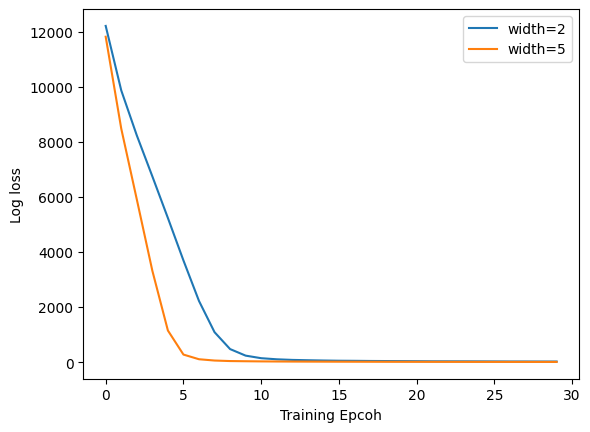

In [ ]:
plt.plot(range(len(hotel_cbow2_loss)),hotel_cbow2_loss,label='width=2')
plt.plot(range(len(hotel_cbow5_loss)),hotel_cbow5_loss,label='width=5')
plt.xlabel('Training Epcoh')
plt.ylabel('Log loss')
plt.legend()
plt.show()

Yes. From the training log plot, we can see that training loss decreases quickly using width of 5 than that of 2.
And the loss of width of 2 is higher than then that of 5. Therefore, the predictions made by the model sensitive towards the context size.

### 1.6 Train CBOW2 with a context width of 2 (in both directions) for the Sci-Fi story dataset

In [ ]:
width=2
scifi_data,scifi_word_to_ix = custom_preprocess('scifi',width)
scifi_training_data = LanguageDataset(scifi_data,scifi_word_to_ix)
scifi_loader = DataLoader(scifi_training_data,batch_size=8,shuffle=True)

In [ ]:
scifi_cbow2 = CBOW(len(scifi_word_to_ix),512,512).to(device)
scifi_cbow2_loss = train(scifi_cbow2,scifi_loader,scifi_word_to_ix,num_epoch=30,log_out_epoch=5,loss_return=True)

starting....


  3%|▎         | 1/30 [00:31<15:10, 31.41s/it]

Loss in Epoch 0: 11850.2


 20%|██        | 6/30 [03:08<12:39, 31.65s/it]

Loss in Epoch 5: 3963.35


 37%|███▋      | 11/30 [05:45<09:56, 31.40s/it]

Loss in Epoch 10: 250.03


 53%|█████▎    | 16/30 [08:22<07:18, 31.30s/it]

Loss in Epoch 15: 71.87


 70%|███████   | 21/30 [10:59<04:42, 31.34s/it]

Loss in Epoch 20: 44.74


 87%|████████▋ | 26/30 [13:35<02:05, 31.33s/it]

Loss in Epoch 25: 38.68


100%|██████████| 30/30 [15:40<00:00, 31.36s/it]

Loss in Epoch 29: 37.72


### 2.1 For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. (CBOW2 and optionally for CBOW5)
Make sure that some nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words, retrieve the 5 closest words according to your trained CBOW2 model.    

🗒❓ List them in your report (at the end of this notebook) and comment on the performance of your model: do the neighbours the model provides make sense? Discuss.   


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
reviews = read_file('hotel')

## construct a dictionary to count each word's frequency
cnt_word = {key:0 for key in hotel_word_to_ix.keys()}
for word in reviews:
    cnt_word[word] += 1

num_candidate = 20
## order the dictionary according to the frequency
sorted_cnt_word = sorted(cnt_word.items(),key=lambda item:item[1],reverse=True)
NN_ls = []
JJ_ls = []
VERB_ls = []
for word,freq in sorted_cnt_word:
    tag = nltk.pos_tag([word])[0][1]
    if tag=='NN' and len(NN_ls)<num_candidate:
        NN_ls.append(word)
    elif tag=='JJ' and len(JJ_ls)<num_candidate:
        JJ_ls.append(word)
    elif tag=='VBZ' and len(VERB_ls)<num_candidate:
        VERB_ls.append(word)
    else:
        continue
print(NN_ls)
print(JJ_ls)
print(VERB_ls)

['hotel', 'room', 'nt', 'staff', 'stay', 'location', 'stayed', 'service', 'time', 'night', 'day', 'beach', 'clean', 'breakfast', 'food', 'place', 'resort', 'pool', 'walk', 'excellent']
['great', 'good', 'nice', 'small', 'little', 'comfortable', 'free', 'large', 'new', 'big', 'fantastic', 'bad', 'quiet', 'old', 'main', 'hot', 'overall', 'english', 'easy', 'different']
['makes', 'goes', 'takes', 'gets', 'comes', 'says', 'gives', 'wants', 'includes', 'provides', 'faces', 'appears', 'adds', 'sells', 'requires', 'expects', 'follows', 'owns', 'continues', 'reflects']


In [ ]:
cbow2_embed = hotel_cbow2.embeddings.weight.cpu()
hotel_ix_to_word = {val:key for key,val in hotel_word_to_ix.items()}
for word in ['hotel','room','pool','great','good','different','goes','makes','expects']:
    embed_vec  = cbow2_embed[hotel_word_to_ix[word],:]
    dist = torch.sqrt(torch.sum((cbow2_embed - embed_vec)**2,dim=-1))
    closet_ixs = torch.argsort(dist)[1:6]
    closet_words = [hotel_ix_to_word[ix.item()] for ix in closet_ixs]
    print(f'{word}:{closet_words}')

hotel:['stanford', 'pillowadmittedly', 'stupours', 'greets', 'brasilia']
room:['cliffcafe', 'thoughtout', 'watertowntucked', 'conditiongwe', 'playwalk']
pool:['countrydean', 'brawl', 'mobilis', 'sixed', 'piccolo']
great:['foodsickness', 'appatizers', 'doormen', 'originally', 'validate']
good:['pleasedtip', 'tp', 'aidia', 'cocoçé', 'mountains']
different:['checkers', 'gem', 'dying', 'variedtry', 'nazi']
goes:['buy', 'breakfastlunch', 'duomo', 'origanated', 'queing']
makes:['broussard', 'fernsehrturm', 'acapulco', 'stylishly', 'squareeven']
expects:['waht', 'feature', 'departures', 'shadier', 'amazingpool']


### 2.2 Repeat 2.1 for SciFi Dataset

🗒❓ List your findings for SciFi Dataset as well, similarly to 2.1

In [ ]:
scifi = read_file('scifi')

## construct a dictionary to count each word's frequency
cnt_word = {key:0 for key in scifi_word_to_ix.keys()}
for word in scifi:
    cnt_word[word] += 1

num_candidate = 20
## order the dictionary according to the frequency
sorted_cnt_word = sorted(cnt_word.items(),key=lambda item:item[1],reverse=True)
NN_ls = []
JJ_ls = []
VERB_ls = []
for word,freq in sorted_cnt_word:
    tag = nltk.pos_tag([word])[0][1]
    if tag=='NN' and len(NN_ls)<num_candidate:
        NN_ls.append(word)
    elif tag=='JJ' and len(JJ_ls)<num_candidate:
        JJ_ls.append(word)
    elif tag=='VBZ' and len(VERB_ls)<num_candidate:
        VERB_ls.append(word)
    else:
        continue
## I give 20 candidates for each tag (some may not be proper)
print(NN_ls)
print(JJ_ls)
print(VERB_ls)

['i', 'time', 'man', 'dont', 'way', 'right', 'im', 'think', 'something', 'didnt', 'thought', 'face', 'want', 'head', 'ship', 'look', 'nothing', 'thing', 'room', 'hand']
['other', 'little', 'good', 'new', 'much', 'old', 'own', 'few', 'last', 'such', 'many', 'small', 'same', 'great', 'big', 'ive', 'next', 'open', 'second', 'dead']
['is', 'has', 'does', 'says', 'seems', 'makes', 'comes', 'faces', 'goes', 'gets', 'wants', 'takes', 'gives', 'appears', 'holds', 'requires', 'follows', 'believes', 'includes', 'carries']


3 nouns:['time', 'man','room']

3 adjectives:['good', 'new','dead']

3 verbs:['makes','goes','carries']


The frequently occurring words are: 'time', 'man', 'new', 'good', 'goes', 'makes'

The rarely occurring words are: 'room', 'dead', 'carries'

In [ ]:
scifi_cbow2_embed = scifi_cbow2.embeddings.weight.cpu()
scifi_ix_to_word = {val:key for key,val in scifi_word_to_ix.items()}
for word in ['time', 'man','room','good', 'new','dead','makes','goes','carries']:
    embed_vec  = scifi_cbow2_embed[scifi_word_to_ix[word],:]
    dist = torch.sqrt(torch.sum((scifi_cbow2_embed - embed_vec)**2,dim=-1))
    closet_ixs = torch.argsort(dist)[1:6]
    closet_words = [scifi_ix_to_word[ix.item()] for ix in closet_ixs]
    print(f'{word}:{closet_words}')

time:['btub', 'chargip', 'kidneyshaped', 'huriy', 'jnitiiin']
man:['busings', 'slamup', 'indemnity', 'bureau', 'lighters']
room:['amsirprint', 'floridity', 'acclimate', 'obedience', 'retz']
good:['earthlike', 'scrateh', 'neutrinos', 'ught', 'pocketbooks']
new:['illlit', 'astrofiautical', 'entraocc', 'brooches', 'riddance']
dead:['dwuuhrr', 'emerson', 'pukka', 'camerarange', 'ikfiofi']
makes:['toilettraining', 'hullscrapings', 'runts', 'yery', 'truereeding']
goes:['extensor', 'trinexus', 'lascarrobot', 'houseflag', 'jmfe']
carries:['godcaves', 'disseminated', 'completeness', 'trailer', 'shortness']


### 2.3 🗒❓ How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings? Elaborate.

### 2.4 Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the Sci-fi-based embeddings.

🗒❓ Do they have different neighbours? If yes, can you reason why?

From 2.2, we can see, several same words were selected in 2.1 and 2.2. The neighbors are different. For example, 'room'.
Yes. Because these two corpus are in different topics. Therefore, it will lead to different context for given target word.

### 2.5 🗒❓ What are the differences between CBOW2 and CBOW5 ? Can you "describe" them?    

The main difference between CBOW2 and CBOW5 is the window size. We can also call it as context length. To many context will lead to information redundancy and short context will also lead to lack of information. Therefore, appropriate width is important for CBOW model.

### Report

#1. Training CBOW Embeddings

###1.1 Implement a CBOW Model by completing class CBOW(nn.Module) and train it on raw_text.
The goal of this lab is to train Continuous Bag of Words (CBOW) models on two different datasets: TripAdvisor Hotel Reviews and a Sci-Fi story text. The primary objective is to observe how varying the context window size affects the model's performance. Three CBOW models are trained:

CBOW2: Context width of 2 (in both directions) on the Hotel Reviews dataset.
CBOW5: Context width of 5 (in both directions) on the Hotel Reviews dataset.
CBOW2: Context width of 2 (in both directions) on the Sci-Fi story dataset.

###1.2 Load Datasets tripadvisor_hotel_reviews_reduced.csv and scifi_reduced.txt.

###1.3 Decide preprocessing steps by completing the function def custom_preprocess(). Describe your decisions. Note that it's your choice to create different preprocessing functions for hotel reviews and scifi datasets or use the same preprocessing function.
The preprocessing involves cleaning the text and preparing it for model training, which contains the following things:

a. Lowercasing: All text is converted to lowercase to maintain uniformity and avoid treating words differently due to case variations.

b. Removing Numbers: Numbers are removed since they do not add valuable information for this type of language modeling task.

c. Removing Punctuation: Punctuation marks are stripped as they do not contribute to the word prediction in this setup.

d. Tokenization: The text is tokenized into individual words using nltk.word_tokenize.

e. Stopword Removal, including Hotel Reviews, in which Stopwords are removed to focus on meaningful content words. and Sci-Fi Story, meaning Stopwords are retained, as they could provide valuable contextual information in a literary text.

The training data preparation follows these steps:

a. Reading and Tokenizing the Text: Depending on the dataset, stopwords may or may not be removed.

b. Vocabulary Creation: A set of unique tokens is created, and each word is mapped to an index using a dictionary (word_to_ix).

c. Generating Context-Target Pairs: For each word in the text, a context window of the specified width (e.g., 2 or 5) is used to create context-target pairs for training.

d. Sampling Data: To reduce computational load, a subset of context-target pairs is randomly sampled.
###1.4 Train CBOW2 with a context width of 2 (in both directions) for the Hotel Reviews dataset.

Fo the initial loss, the loss started high, around 12,218.45, indicating that the model began with random initial weights. The loss decreased significantly over the epochs, dropping from 12,218.45 at epoch 0 to 21.5 at epoch 29. This steady decrease in loss suggests that the model effectively learned word representations from the given context.

Training the CBOW2 model on the Hotel Reviews dataset showed that the model can learn effectively even with a smaller context window. However, the results in the next step (1.5) demonstrated that using a larger context window leads to faster convergence and a lower final loss, indicating a potential advantage for larger context sizes in word representation learning.

###1.5 Train CBOW5 with a context width of 5 (in both directions) for the Hotel Reviews dataset. Are predictions made by the model sensitive towards the context size?
Yes. From the training log plot, we can see that training loss decreases quickly using width of 5 than that of 2. And the loss of width of 2 is higher than then that of 5. Therefore, the predictions made by the model sensitive towards the context size.

The initial loss was 11,826.08, slightly lower than the starting loss for the CBOW2 model. The loss decreased much faster compared to CBOW2. By epoch 5, the loss had already dropped significantly to 274.93. By epoch 29, the final loss was 7.71.
What we can conclude from the above results is that training with a larger context window (CBOW5) led to faster convergence and lower final training loss compared to the smaller context (CBOW2) for the hotel reviews. This suggests that the model benefits from additional contextual information in learning word representations.

The loss curves for both CBOW2 and CBOW5 models on the hotel reviews dataset show that the model with the larger context window reaches lower loss values more quickly, indicating better learning efficiency.
###1.6 Train CBOW2 with a context width of 2 (in both directions) for the Sci-Fi story dataset.
The initial loss was 11,850.2, similar to the hotel review dataset.Then, the loss decreased steadily but not as quickly as in the hotel review dataset. By epoch 10, the loss had reduced to 250.03, and by epoch 29, the final loss was 37.72.
Training the CBOW2 model on the Sci-Fi dataset took longer and resulted in a higher final loss compared to the hotel reviews dataset, suggesting that the narrative structure of the literary text is more complex, possibly requiring a different approach to achieve similar performance.

#2. Test your Embeddings
Note - Do the following for CBOW2, and optionally for CBOW5

###2.1 For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. Make sure that some nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words, retrieve the 5 closest words according to your trained CBOW2 model. List them in your report and comment on the performance of your model: do the neighbours the model provides make sense? Discuss.
Nouns: hotel (frequent), room (frequent), pool (rare)

Adjectives: great (frequent), good (frequent), different (rare)

Verbs: goes (frequent), makes (frequent), expects (rare)

Nearest Neighbors

hotel: ['stanford', 'pillowadmittedly', 'stupours', 'greets', 'brasilia']

room: ['cliffcafe', 'thoughtout', 'watertowntucked', 'conditiongwe', 'playwalk']

pool: ['countrydean', 'brawl', 'mobilis', 'sixed', 'piccolo']

great: ['foodsickness', 'appatizers', 'doormen', 'originally', 'validate']

good: ['pleasedtip', 'tp', 'aidia', 'cocoçé', 'mountains']

different: ['checkers', 'gem', 'dying', 'variedtry', 'nazi']

goes: ['buy', 'breakfastlunch', 'duomo', 'origanated', 'queing']

makes: ['broussard', 'fernsehrturm', 'acapulco', 'stylishly', 'squareeven']

expects: ['waht', 'feature', 'departures', 'shadier', 'amazingpool']

The neighbors retrieved for each word appear to be noisy and not entirely related semantically. Many of the closest words seem unrelated to the target word's meaning, which suggests that the embeddings may not capture meaningful relationships effectively. This indicates potential limitations in the quality of training data, model configuration, or insufficient training epochs.
##2.2 Do the same for Sci-Fi dataset.
Nouns: time (frequent), man (frequent), room (rare)

Adjectives: good (frequent), new (frequent), dead (rare)

Verbs: makes (frequent), goes (frequent), carries (rare)

Nearest Neighbors

time: ['btub', 'chargip', 'kidneyshaped', 'huriy', 'jnitiiin']

man: ['busings', 'slamup', 'indemnity', 'bureau', 'lighters']

room: ['amsirprint', 'floridity', 'acclimate', 'obedience', 'retz']

good: ['earthlike', 'scrateh', 'neutrinos', 'ught', 'pocketbooks']

new: ['illlit', 'astrofiautical', 'entraocc', 'brooches', 'riddance']

dead: ['dwuuhrr', 'emerson', 'pukka', 'camerarange', 'ikfiofi']

makes: ['toilettraining', 'hullscrapings', 'runts', 'yery', 'truereeding']

goes: ['extensor', 'trinexus', 'lascarrobot', 'houseflag', 'jmfe']

carries: ['godcaves', 'disseminated', 'completeness', 'trailer', 'shortness']

Similar to the hotel reviews, the neighbors retrieved are mostly unrelated to the original word. The embedding space for the Sci-Fi dataset appears noisy, with many nonsensical or uncommon terms being close neighbors. This suggests that the model might have struggled with generalization due to the complex vocabulary in Sci-Fi texts.

##2.3 How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings? Elaborate.
The quality of embeddings from the hotel reviews dataset appears slightly better than the Sci-Fi embeddings. This is likely due to the simpler vocabulary and more consistent word usage in the hotel reviews. In contrast, the Sci-Fi dataset contains more unusual or domain-specific terms, making it harder for the model to learn meaningful embeddings.
##2.4 Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the Sci-fi-based embeddings. Do they have different neighbours? If yes, can you reason why?
From 2.2, we can see, several same words were selected in 2.1 and 2.2. The neighbors are different. Yes. Because these two corpus are in different topics. Therefore, it will lead to different context for given target word.
For example, we retrieved the five closest neighbors for the word "room" from both the hotel reviews and Sci-Fi embeddings:

Hotel Review Embeddings: ['cliffcafe', 'thoughtout', 'watertowntucked', 'conditiongwe', 'playwalk']

Sci-Fi Embeddings: ['amsirprint', 'floridity', 'acclimate', 'obedience', 'retz']

The neighbors differ significantly, reflecting the different contexts in each dataset. In hotel reviews, "room" is associated with words related to hospitality. In the Sci-Fi dataset, the context is much more abstract, potentially relating to different types of spaces or sci-fi concepts.

##2.5 What are the differences between CBOW2 and CBOW5 ? Can you "describe" them?
The primary difference between CBOW2 and CBOW5 is the context window size.

CBOW2 uses a smaller context window (4 words total), potentially leading to a limited view of the target word's surroundings, which can be beneficial for simpler texts but may lack the richness needed for more complex language.

CBOW5 uses a larger context window (10 words total), which helps capture broader contextual relationships but may introduce noise if the additional words are not informative.